In [1]:
#pip install joypy

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python3.9 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
!pip install statsmodels
from scipy.optimize import curve_fit
from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit
import colorsys

import joypy
from matplotlib import cm
from sklearn.datasets import load_iris

#%load_ext lab_black

pd.set_option("max_columns", 500)

In [7]:
new_df = pd.read_csv("df_norm_3_time_all_median.csv")

In [8]:
new_df["exp_pos_rel_cell"] = (
    new_df["experiment_foldername"]
    + "_"
    + new_df["Position_n"].astype(str)
    + "_"
    + new_df["relative_ID"].astype(str)
)

new_df.exp_pos.unique()

array(['exp5_Position_1', 'exp5_Position_2', 'exp5_Position_3',
       'exp4_Position_1', 'exp4_Position_2', 'exp4_Position_4',
       'exp4_Position_5', 'exp1_Position_1', 'exp1_Position_2'],
      dtype=object)

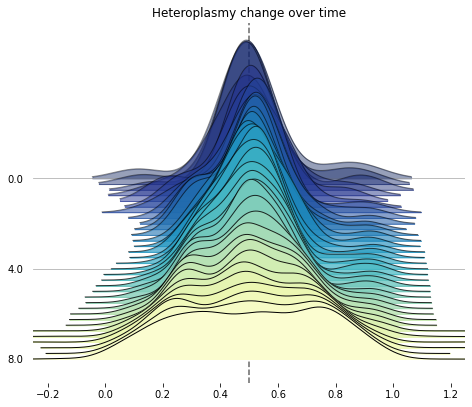

In [9]:
labels=[y if y%10==0 or y == 4.0 or y == 8.0 else None for y in list(new_df.time.unique())]
fig, axes = joypy.joyplot(new_df, by="time", column="h", range_style='own', 
                          overlap=3, linewidth=1, legend=False,  fade=True,labels=labels, 
                          grid="y", figsize=(6,5), x_range=[-0.25,1.25],
                          title="Heteroplasmy change over time",
                          colormap=cm.YlGnBu_r)

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

plt.axvline(x=0.5, color='k', linestyle='--', alpha = 0.6) 
#plt.axvline(x=0.3, color='k', linestyle='--', alpha = 0.3) 
#plt.axvline(x=0.7, color='k', linestyle='--', alpha = 0.3) 

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('heteroplasmy_distribution_over_time_3d_data_joyplot_correct.svg', transparent= True)

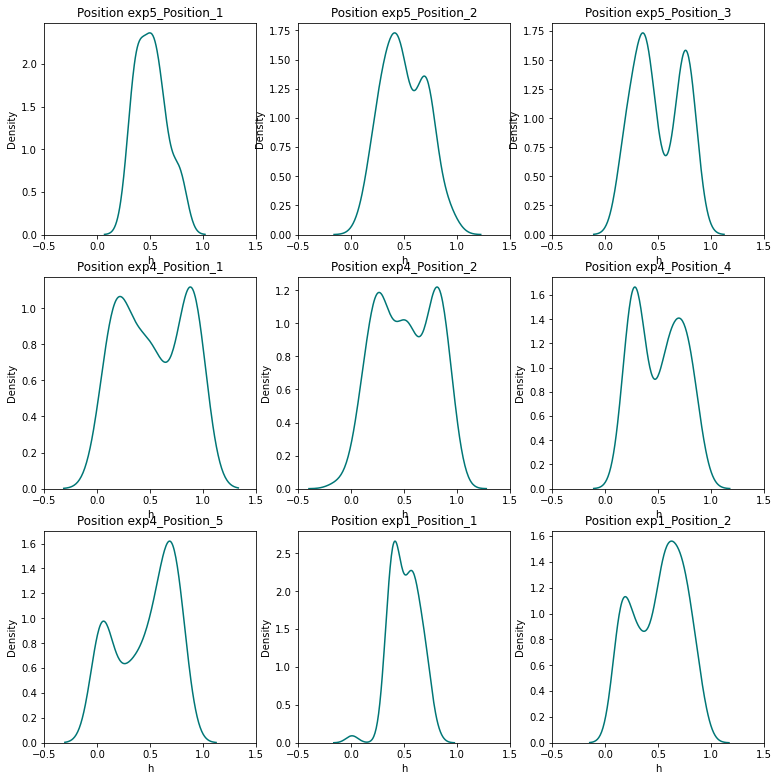

In [10]:
last_time = new_df[new_df['time'] == 8.00]
grouped_per_pos = last_time.groupby('exp_pos')
num_positions = len(grouped_per_pos)

ffig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
x_range = [-0.5, 1.5]

for i, pos in enumerate(last_time['exp_pos'].unique()):
    pos_data = last_time[last_time['exp_pos'] == pos]
    labels = [None] * len(pos_data['time'].unique())

    row = i // 3
    col = i % 3
    ax = axes[row, col]

    sns.kdeplot(data=pos_data, x="h", ax=ax, color = '#007676')
    ax.set_xlim(x_range)
    ax.set_title(f"Position {pos}")

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
#plt.savefig('cor_heteroplasmy_distribution_last_timepoint_allpos_kdeplot_correct.svg', transparent= True)

In [11]:
# take homo thresholds 0.3 and 0.7 and call all in-between cells hetero
new_df['phenotype'] = new_df['h'].apply(lambda x: 'homo' if x<0.33 or x >0.71 else 'hetero')

In [12]:
# get percentage of homo cells in time
perc_homo = new_df[new_df['phenotype'] == 'homo'].groupby('time')['phenotype'].count()/ new_df.groupby('time')['phenotype'].count()*100

In [13]:
perc_homo.reset_index(name = 'perc_homo_cells')
perc_homo_df = pd.DataFrame(perc_homo)
perc_homo_df = perc_homo_df.rename_axis('index').reset_index()
perc_homo_df = perc_homo_df.rename(columns ={'index': 'time'})
perc_homo_df

,time,phenotype
0,0.00,15.789474
1,0.25,15.000000
2,0.50,11.111111
3,0.75,13.333333
4,1.00,18.181818
5,1.25,18.421053
6,1.50,15.217391
7,1.75,16.981132
8,2.00,16.393443
9,2.25,14.705882


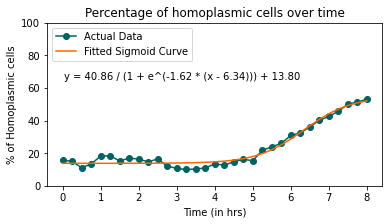

In [25]:
plt.figure(figsize=(6, 3))

xdata = perc_homo_df['time']
ydata = perc_homo_df['phenotype']

def sigmoid_scaled(x, x0, k, b, max_value):
    y = max_value / (1 + np.exp(-k * (x - x0))) + b
    return y

# Initial guess
p0 = [np.median(xdata), 1, min(ydata), 100]  # Adjust the initial guess as needed

# Curve fitting
popt, pcov = curve_fit(sigmoid_scaled, xdata, ydata, p0, method='dogbox')

# Generate y values for the fitted curve
y_fit = sigmoid_scaled(xdata, *popt)

# Plot the original data
plt.plot(xdata, ydata, marker='o', linestyle='-', label='Actual Data', color='#006262')

# Plot the fitted sigmoid curve
plt.plot(xdata, y_fit, linestyle='-', label='Fitted Sigmoid Curve', color='#FF6600')

# Display the fitted parameters
equation_text = f'y = {popt[3]:.2f} / (1 + e^(-{popt[1]:.2f} * (x - {popt[0]:.2f}))) + {popt[2]:.2f}'
plt.text(0.05, 0.7, equation_text, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

plt.ylim(0, 100)  # Set the y-axis limit to 100
plt.title('Percentage of homoplasmic cells over time')
plt.ylabel('% of Homoplasmic cells')
plt.xlabel('Time (in hrs)')
plt.legend(loc='upper left')
plt.savefig('homoplasmic_cells_percentage_over_time_sigmoid_curve_fit_max100.svg', transparent = True)

In [32]:
specific_x_values = [0, 1.5, 3, 4.5, 6, 7.5]

# Calculate corresponding y-values using the sigmoid equation

#y_values = popt[0] / (1 + np.exp(-popt[2] * (np.array(specific_x_values) - popt[1]))) + popt[3]
y_values =  popt[3] / (1 + np.exp(-popt[1] * (np.array(specific_x_values)  - popt[0]))) + popt[2]

# Print the result
print("Specific x-values:", specific_x_values)
print("Corresponding y-values:", y_values)

Specific x-values: [0, 1.5, 3, 4.5, 6, 7.5]
Corresponding y-values: [13.79674377 13.81109014 13.97429034 15.75038001 28.69828957 49.25057002]


In [34]:
s_curve_df = pd.DataFrame({'time': specific_x_values, 'perc_homoplasmic_cells': y_values})
s_curve_df

,time,perc_homoplasmic_cells
0,0.0,13.796744
1,1.5,13.811090
2,3.0,13.974290
3,4.5,15.750380
4,6.0,28.698290
5,7.5,49.250570
